In [ ]:
# Step 1: Install required libraries :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}
!pip install transformers datasets scikit-learn shap umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 23.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
# Step 2: Mount Drive or upload CSV :contentReference[oaicite:2]{index=2}:contentReference[oaicite:3]{index=3}
from google.colab import files, drive

# Option A: upload directly
uploaded = files.upload()  # then select model_data_2.csv

# Option B: mount Google Drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/path/to/your/folder


Saving model_data_2.csv to model_data_2.csv


In [ ]:
# Step 3: Imports and device setup
import pandas as pd
import torch
import pickle
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from google.colab import files as colab_files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# # Step 4: Load & prepare your data :contentReference[oaicite:4]{index=4}:contentReference[oaicite:5]{index=5}
# df = pd.read_csv("model_data_.csv")

# # If your file already has 'text' and 'label', skip the next two lines.
# # Otherwise—for example, if you have title/source columns—combine them:
# # df['text'] = df['title'].fillna('') + ' ' + df['source'].fillna('') + ' ' + df['text'].fillna('')

# dataset = Dataset.from_pandas(df[['text', 'label']])


In [ ]:
import pandas as pd
from datasets import Dataset

df = pd.read_csv("model_data_.csv",encoding='utf-8')
print(df.columns)
print(df.head())


Index(['text', 'source', 'category', 'labels', 'cleaned_text'], dtype='object')
                                                text  \
0  MADISON, Wis. -- More than 700 million adults ...   
1  Wilmington, DE, December 17, 2018 - The CRISPR...   
2  About 3 million people in the US are diagnosed...   
3  Newswise — Thousands of people can take heart ...   
4  Researchers at Johns Hopkins Medicine have ide...   

                     source  \
0   https://web.archive.org   
1   https://web.archive.org   
2   https://web.archive.org   
3  https://www.newswise.com   
4   https://web.archive.org   

                                            category      labels  \
0  Biology, Nutrition/Nutrients, Chemistry/Physic...  Unreliable   
1  Biology, Nutrition/Nutrients, Chemistry/Physic...  Unreliable   
2  Biology, Nutrition/Nutrients, Chemistry/Physic...        FAKE   
3  Biology, Nutrition/Nutrients, Chemistry/Physic...        FAKE   
4  Biology, Nutrition/Nutrients, Chemistry/Physic...  Un

In [ ]:
# 2) Pick the column you really want to feed into BERT.
#    In your case you have both 'text' (the raw paragraphs) and
#    'cleaned_text' (lowercased, punctuation-stripped). Use whichever
#    you prefer; here I'll use 'cleaned_text'.
df["cleaned_text"] = df["cleaned_text"].fillna("").astype(str)

# 3) Rename it to exactly "text" for the tokenizer function:
hf_df = df.rename(
    columns={"cleaned_text": "text"}
)

In [ ]:
df['labels']

,labels
0,Unreliable
1,Unreliable
2,FAKE
3,FAKE
4,Unreliable
...,...
8997,Unreliable
8998,Unreliable
8999,Unreliable
9000,Unreliable


In [ ]:
# 1. Bucket raw claims into named labels
df.dropna(subset=["labels"], inplace=True)
df["labels"] = df["labels"].apply(lambda x: tuple(x) if isinstance(x, list) else x)

df["labels"] = df["labels"].map({
    "Realiable": "Reliable",
    "false": "Fake",
    "Unreliable": "Unreliable",
    "SUPPORTS": "Reliable",
    "REFUTES": "Fake",
    "NOT ENOUGH INFO": "NOT ENOUGH INFO",
    "unknown": "NOT ENOUGH INFO",
    "Not Enough Experts": "NOT ENOUGH INFO",
    "true": "Reliable",
    "mixture": "Unreliable",
    "Inaccurate": "Unreliable",
    "mostly-false": "Unreliable",
    "Reliable": "Reliable",
    "FAKE": "Fake",
    "Unsupported": "Unreliable",
    "Affirmative": "Reliable",
    "unproven": "Unreliable",
    "Misleading": "Unreliable",
    "mostly-true": "Reliable",
    "Incorrect": "Fake",
    "Negative": "Fake",
    "Flawed_Reasoning": "Unreliable",
    "undetermined": "Unreliable",
    "Lacks_Context": "Unreliable",
    "miscaptioned": "Unreliable",
    "correct-attribution": "Reliable",
    "Correct.": "Reliable",
    "False": "Fake",
    "Mostly_Accurate": "Reliable",
    "Partially_Correct": "Reliable",
    "legend": "NOT ENOUGH INFO",
    "outdated": "NOT ENOUGH INFO",
    "Uncertain": "NOT ENOUGH INFO",
    "labeled-satire": "NOT ENOUGH INFO",
    "Correct": "Reliable",
    "Spins the Facts": "Unreliable",
    "Accurate": "Reliable",
    "misattributed": "Unreliable",
    "multiple--see-below": "NOT ENOUGH INFO",
    "multiple": "NOT ENOUGH INFO",
    "There is no evidence for this.": "Fake",
    "There is no evidence to support this.": "Fake",
    "partly-true": "Reliable"

}).fillna("NOT ENOUGH INFO")


In [ ]:
df['labels'].value_counts()

,count
labels,
Reliable,2996
NOT ENOUGH INFO,2326
Unreliable,1864
Fake,1816


In [ ]:
# 2. Map named labels to exactly the integers you want
df["labels"] = df["labels"].map({
    "Unreliable":       0,
    "Fake":             1,
    "Reliable":         2,
    "NOT ENOUGH INFO":  3
})

# # Ensure the label column is of integer type
df["labels"] = df["labels"].astype(int)

# # 4. Then build your HF dataset as before:
hf_df = df[["cleaned_text","labels"]].rename(columns={"cleaned_text":"text"})
dataset = Dataset.from_pandas(hf_df)

In [ ]:
df['labels'].isna().sum() #should be 0

np.int64(0)

In [ ]:
df['labels'].unique()

array([0, 1, 2, 3])

In [ ]:
# 1) Show the mapping dictionary you used
mapping = {
    "Unreliable":      0,
    "Fake":            1,
    "Reliable":        2,
    "NOT ENOUGH INFO": 3
}
print("Expected mapping:", mapping)

# 2) Verify that only 0–3 appear in your df
print("Unique label values after recoding:", sorted(df["label"].unique()))

# 3) Show how many examples of each class you have
print("\nCounts per label:")
print(df["label"].value_counts().sort_index())

# 4) (Optional) Peek at a few rows of each class
for lbl, name in mapping.items():
    print(f"\nSample rows for class '{lbl}' ({mapping[lbl]}):")
    display(df[df["label"] == mapping[lbl]].head(3))


In [ ]:

# Now your tokenize_fn will receive `examples["text"]` as a List[str]
# and you can safely do:
from transformers import AutoTokenizer
checkpoint = "distilbert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_fn(examples):
    return tokenizer(
        str(examples["text"]),
        truncation=True,
        padding="max_length",
        max_length=512
    )

# dataset = Dataset.from_pandas(df[['text', 'label']])
# tokenized_ds = dataset.map(tokenize_fn)
# tokenized_ds = tokenized_ds.rename_column("label", "labels")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
len(dataset)

9002

In [ ]:
# Step 6: Split into train/test
# split     = tokenized_ds.train_test_split(test_size=0.2,stratify=df['labels'])
# train_ds  = split["train"]
# eval_ds   = split["test"]
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

# Convert back to Hugging Face Dataset
dataset_tr=Dataset.from_pandas(train_df)
dataset_tst=Dataset.from_pandas(val_df)
train_dataset = dataset_tr.map(tokenize_fn)
val_dataset = dataset_tst.map(tokenize_fn)

Map:   0%|          | 0/7201 [00:00<?, ? examples/s]

Map:   0%|          | 0/1801 [00:00<?, ? examples/s]

In [ ]:
# Step 7: Load model & send to GPU :contentReference[oaicite:8]{index=8}:contentReference[oaicite:9]{index=9}
from transformers import AutoModelForSequenceClassification

checkpoint = 'distilbert-base-uncased'
num_labels = df["labels"].nunique()
model      = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels
)
model.to(device)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./bert_misinformation",
    do_train=True,             # enable training
    do_eval=True,              # enable evaluation
    num_train_epochs=4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    logging_steps=100,         # log every 500 steps
    eval_steps=100,            # evaluate every 500 steps
    save_steps=100,            # checkpoint every 500 steps
    save_total_limit=1,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-13-5f31dacf972f>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.948600
200,0.783200
300,0.639300
400,0.574500
500,0.488800
600,0.388600
700,0.363000
800,0.270800
900,0.254600


TrainOutput(global_step=904, training_loss=0.5223003662792982, metrics={'train_runtime': 1392.8885, 'train_samples_per_second': 20.679, 'train_steps_per_second': 0.649, 'total_flos': 3815727042183168.0, 'train_loss': 0.5223003662792982, 'epoch': 4.0})

In [ ]:
# Step 9: Save weights as a .pkl and download
state_dict = model.state_dict()
with open("model_weights.pkl", "wb") as f:
    pickle.dump(state_dict, f)

colab_files.download("model_weights.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report

# 1) Re-instantiate the model architecture
checkpoint = "bert-base-uncased"
num_labels = 4  # or df['label'].nunique()
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels
)

# 2) Load the pickled state_dict
with open("model_weights.pkl", "rb") as f:
    state_dict = pickle.load(f)
model.load_state_dict(state_dict)
model.to(device)

# 3) Wrap in a Trainer for easy batching
# We only need evaluation, so we’ll supply a dummy args object
eval_args = TrainingArguments(
    output_dir="eval",
    per_device_eval_batch_size=8,
    do_train=False,
    do_eval=True,
    logging_dir=None,
)

trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=val_dataset,     # your 20% split
    tokenizer=tokenizer,
)

# 4) Run evaluation
metrics = trainer.evaluate()
print("🔍 Eval metrics:", metrics)

# 5) Get raw predictions & compute a classification report
preds_output = trainer.predict(val_dataset)
logits = preds_output.predictions        # shape (N, num_labels)
y_pred = np.argmax(logits, axis=-1)
y_true = preds_output.label_ids

print("\n📊 Accuracy:", accuracy_score(y_true, y_pred))
print("\n📝 Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=["Unreliable","Fake","Reliable","NOT ENOUGH INFO"]
))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-16-5423232e0996>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔍 Eval metrics: {'eval_loss': 0.6398003101348877, 'eval_model_preparation_time': 0.0025, 'eval_runtime': 26.3865, 'eval_samples_per_second': 68.255, 'eval_steps_per_second': 8.565}

📊 Accuracy: 0.7573570238756246

📝 Classification Report:

                 precision    recall  f1-score   support

     Unreliable       0.74      0.71      0.72       373
           Fake       0.62      0.57      0.59       363
       Reliable       0.76      0.79      0.78       600
NOT ENOUGH INFO       0.87      0.89      0.88       465

       accuracy                           0.76      1801
      macro avg       0.75      0.74      0.74      1801
   weighted avg       0.75      0.76      0.76      1801



# Network plot

In [21]:
def get_cls_embeddings(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.distilbert(**inputs, output_hidden_states=True)
    cls_embeddings = outputs.hidden_states[-1][:,0,:]  # CLS token
    return cls_embeddings.cpu().numpy()

sample_texts = df['text'][:100]
embeddings = get_cls_embeddings(sample_texts.tolist())


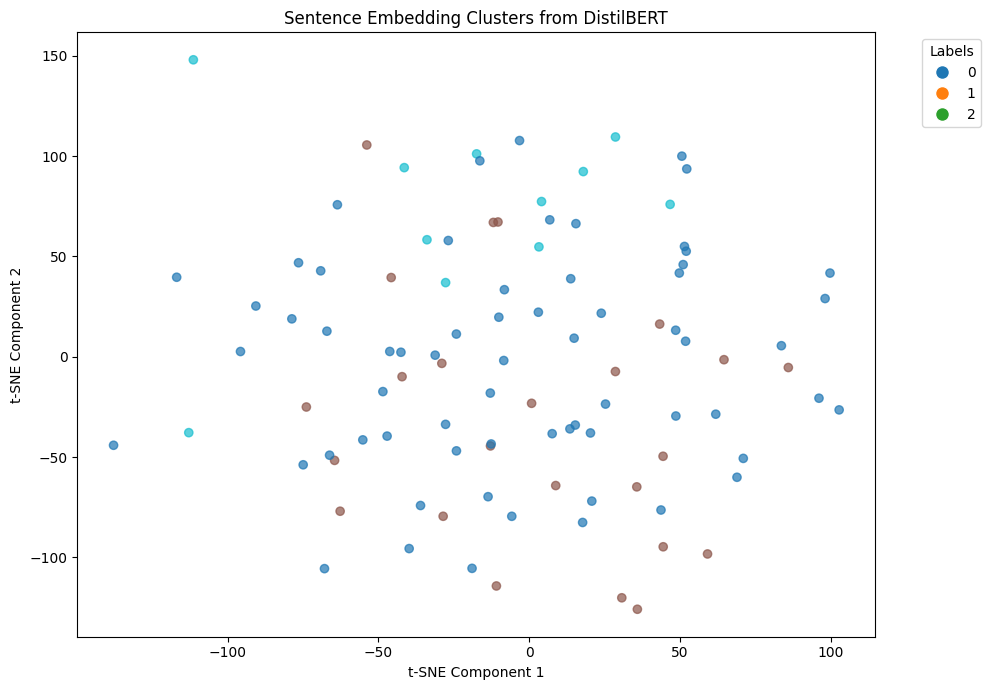

In [56]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume `embeddings` shape is [num_samples, embedding_dim]
# And `df['labels']` contains the class labels

# 1. Reduce dimensionality using t-SNE
tsne = TSNE(n_components=3, random_state=42)
reduced = tsne.fit_transform(embeddings)

# 2. Encode labels to integers for coloring
labels = df['labels'][:len(reduced)]
label_codes = labels.astype('category').cat.codes
unique_labels = labels.astype('category').cat.categories

# 3. Plot with proper coloring and legend
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=label_codes, cmap='tab10', alpha=0.7)

# 4. Create a custom legend
handles = []
for i, label in enumerate(unique_labels):
    handles.append(plt.Line2D([], [], marker='o', color='w', markerfacecolor=plt.cm.tab10(i/10), label=label, markersize=10))
plt.legend(handles=handles, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Sentence Embedding Clusters from DistilBERT")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()


# SHAP: To understand which tokens shape the model's decision, by identifying positive and negative contributors.

In [51]:

# 1. Create a pipeline with return_all_scores=True for SHAP compatibility
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# 2. Wrap the pipeline with a SHAP explainer
explainer = shap.Explainer(pipe)

# 3. Get and truncate the input text
text = df['text'][0][:510]
# text="The government asked people to refrain from taking vaccines"

# Tokenize the input to ensure truncation matches model expectations
tokens = tokenizer.tokenize(text)

# Leave space for [CLS] and [SEP]
max_tokens = 510
truncated_tokens = tokens[:max_tokens]

# Convert back to a string
truncated_text = tokenizer.convert_tokens_to_string(truncated_tokens)

# 4. Explain the prediction on the sample
shap_values = explainer([truncated_text])

# 5. Plot SHAP values over tokens
shap.plots.text(shap_values[0])


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


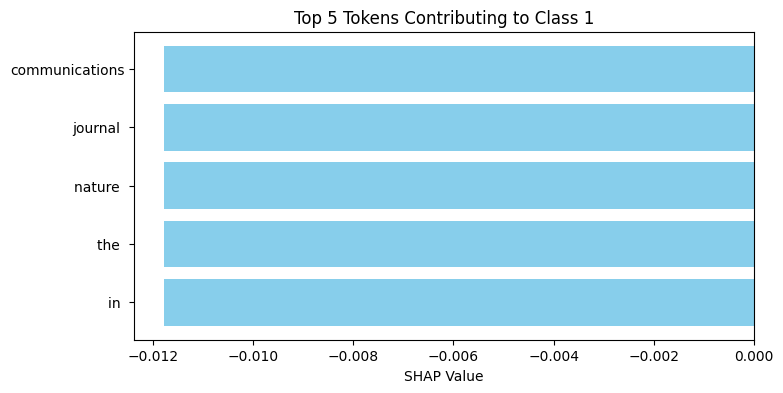

In [50]:
import matplotlib.pyplot as plt

# Bar plot of top 5 tokens by SHAP value
plt.figure(figsize=(8, 4))
plt.barh(top_words, top_scores, color='skyblue')
plt.xlabel('SHAP Value')
plt.title(f'Top 5 Tokens Contributing to Class {class_idx}')
plt.gca().invert_yaxis()  # Highest at top
plt.show()
